# Visualization of UCE Embeddings

In [1]:
import scanpy as sc
import joblib

# train a logistic regression classifier to predict coarse cell type from UCEs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
data_dir = '/dfs/user/ayushag/diffusion/data/uce_data/'

In [6]:
adata_tabula = sc.read_h5ad(data_dir + 'new_tabula_sapiens_ep_8_sn_2013249_nlayers_33_sample_size_1024.h5ad')

In [4]:
adata_tabula

AnnData object with n_obs × n_vars = 1194952 × 19567
    obs: 'donor', 'tissue', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'old_index', 'assay', 'sample_id', 'sample', 'replicate', '10X_run', '10X_barcode', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_ontology_class', 'cell_ontology_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'age', 'sex', 'ethnicity', 'n_genes'
    var: 'ensembl_id', 'gene_symbol', 'genome', 'mt', 'ercc', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std', 'n_cells'
    obsm: 'X_uce'

In [8]:
adata_10k_33l = sc.read_h5ad(data_dir + 'coarse_uce_10000_per_dataset_33l_8ep.h5ad')

In [9]:
adata_10k_33l

AnnData object with n_obs × n_vars = 2303565 × 1280
    obs: 'cell_type', 'tissue', 'idx', 'dataset', 'coarse_tissue', 'coarse_cell_type', 'species', 'coarse_tissue_2'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [10]:
adata = adata_10k_33l

In [6]:
if 'X_umap' not in adata.obsm.keys():
    print(f'Computing UMAP for {adata}')
    # Compute a UMAP based on adata.obsm['X_uce'] visualizing different perturbations from adata.obs['gene']
    sc.pp.neighbors(adata, use_rep='X_uce', n_neighbors=15, metric='cosine')
    sc.tl.umap(adata)

In [7]:
adata.obs['coarse_cell_type'].value_counts()

coarse_cell_type
neuron                                  939277
oligodendrocyte                         196002
epithelial                              184984
t cell                                  168607
endothelial                              84222
b cell                                   80352
fibroblast                               77175
macrophage                               73660
stem                                     71701
monocyte                                 70996
astrocyte                                56443
glial                                    44057
lymphoid                                 32677
pneumocyte                               32625
muscle                                   26123
mesenchymal                              25368
thymocyte                                21316
erythroid                                20058
tumor                                    20055
endocrine                                14145
leukocyte                                13

In [9]:
# Remove rows where y contains NaN values
mask = ~adata.obs['coarse_cell_type'].isna()
X = adata.X[mask]
y = adata.obs['coarse_cell_type'][mask]

# Proceed with the split and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9666247405644975


In [11]:
import joblib
joblib.dump(clf, f'/dfs/user/ayushag/diffusion/saved_models/classifiers/lr_coarse_ct.pkl')

['/dfs/user/ayushag/diffusion/classifier_saved/lr_coarse_ct.pkl']

In [12]:
adata.obs['coarse_tissue'].value_counts()

coarse_tissue
brain                  1257706
blood                   233477
intestines              173106
lung                    158453
kidney                  116683
female reproductive     100337
eye                      56390
bone                     39675
liver                    37537
heart                    26507
male reproductive        21730
skin                     21471
spleen                   19542
thymus                   18022
pancreas                 17498
esophagus                11539
muscle                   10183
nose                      9461
adipose                   8818
stomach                   6032
tongue                    2896
bladder                   1145
Name: count, dtype: int64

In [13]:
# train a logistic regression classifier to predict tissue type from UCEs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Remove rows where y contains NaN values
mask = ~adata.obs['coarse_tissue'].isna()
X = adata.X[mask]
y = adata.obs['coarse_tissue'][mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9912727974743919


In [14]:
joblib.dump(clf, f'/dfs/user/ayushag/diffusion/saved_models/classifiers/lr_coarse_tis.pkl')

['/dfs/user/ayushag/diffusion/saved_models/classifiers/lr_coarse_tis.pkl']

/lfs/local/0/ayushag/env/micromamba/envs/diff/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/lfs/local/0/ayushag/env/micromamba/envs/diff/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


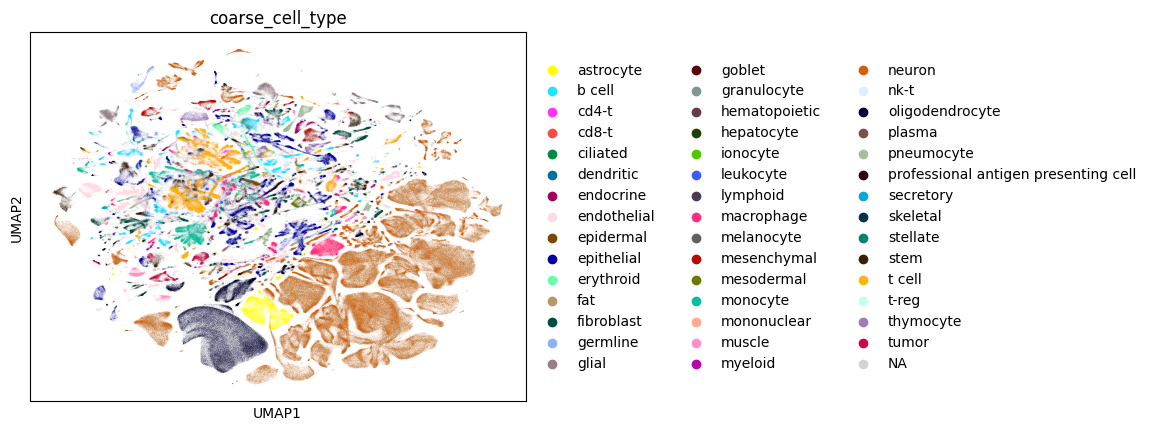

In [15]:
sc.pl.umap(adata, color='coarse_cell_type')

/lfs/local/0/ayushag/env/micromamba/envs/diff/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/lfs/local/0/ayushag/env/micromamba/envs/diff/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


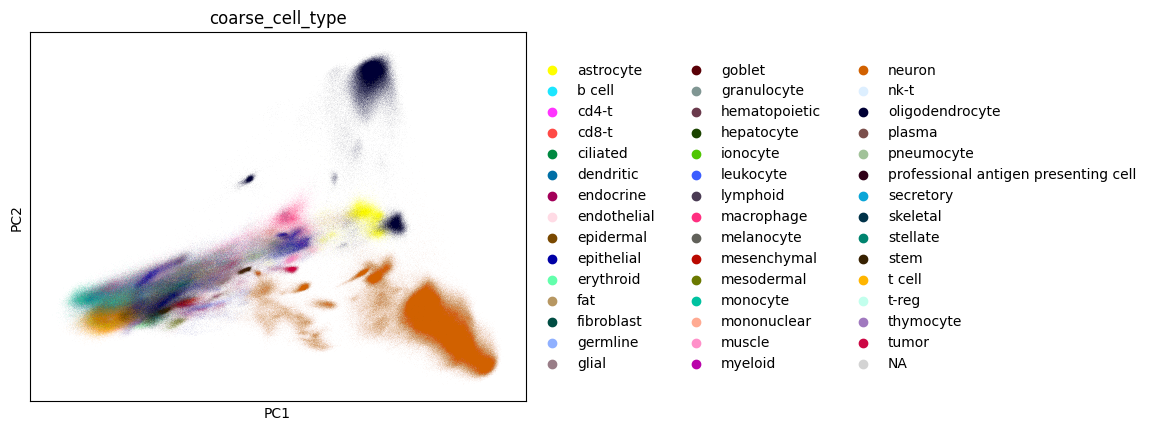

In [16]:
sc.pl.pca(adata, color='coarse_cell_type')

/lfs/local/0/ayushag/env/micromamba/envs/diff/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/lfs/local/0/ayushag/env/micromamba/envs/diff/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


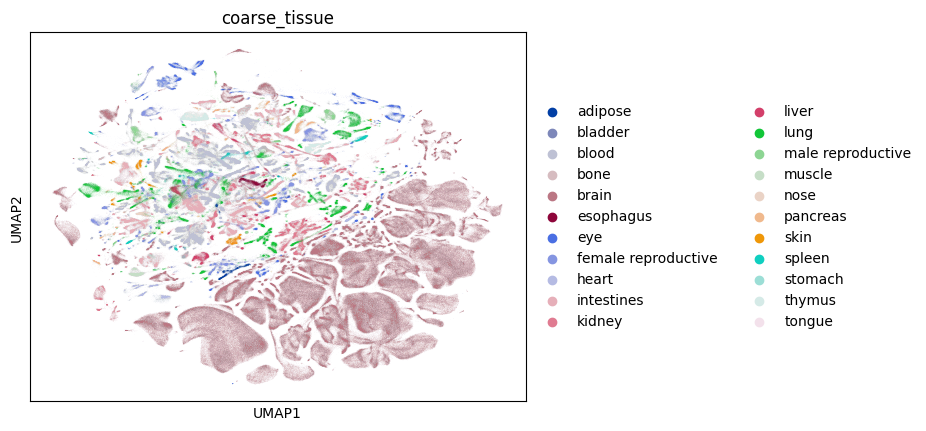

In [17]:
sc.pl.umap(adata, color='coarse_tissue')

/lfs/local/0/ayushag/env/micromamba/envs/diff/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/lfs/local/0/ayushag/env/micromamba/envs/diff/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


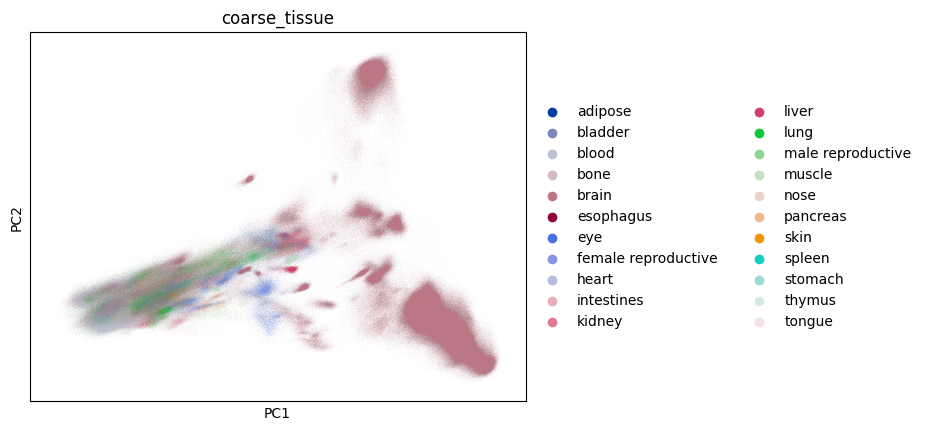

In [18]:
sc.pl.pca(adata, color='coarse_tissue')